In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -q -y -c conda-forge physics-tenpy

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - physics-tenpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.3.7           |  py310h0a54255_0         120 KB  conda-forge
    ca-certificates-2023.5.7   |       hbcca054_0         145 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    cudatoolkit-11.8.0         |      h37601d7_11       635.9 MB  conda-forge
    h5py-3.

In [ ]:
import numpy as np
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.models.lattice import Chain
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg
import logging
logging.basicConfig(level=logging.INFO)
import h5py
from tenpy.tools import hdf5_io
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [ ]:
__all__ = ['CustomTFIModel', 'CustomTFIChain']


class CustomTFIModel(CouplingMPOModel):
    r"""Transverse field Ising model on a general lattice.

    The Hamiltonian reads:

    .. math ::
        H = - \sum_{\langle i,j\rangle, i < j} \mathtt{gzz} \sigma^z_i \sigma^z_{j}
            - \sum_{i} \mathtt{gx} \sigma^x_i
            - \sum_{i} \mathtt{gzxz} \sigma^z_i \sigma^x_{i+1} \sigma^z_{i+2}

    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs, each pair appearing
    exactly once.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.

    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`CustomTFIModel` below.

    Options
    -------
    .. cfg:config :: CustomTFIModel
        :include: CouplingMPOModel

        conserve : None | 'parity'
            What should be conserved. See :class:`~tenpy.networks.Site.SpinHalfSite`.
        sort_charge : bool | None
            Whether to sort by charges of physical legs.
            See change comment in :class:`~tenpy.networks.site.Site`.
        gzz, gx : float | array
            Coupling as defined for the Hamiltonian above.

    """
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        sort_charge = model_params.get('sort_charge', None)
        site = SpinHalfSite(conserve=conserve, sort_charge=sort_charge)
        return site

    def init_terms(self, model_params):
        gzz = np.asarray(model_params.get('gzz', 1.))
        gx = np.asarray(model_params.get('gx', 1.))
        gzxz = np.asarray(model_params.get('gzxz', 0.))
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-gzz, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-gx, u, 'Sigmax')
        ## only for 1D
        for u in range(len(self.lat.unit_cell)):
            # self.add_multi_coupling(+gzxz, u, "Sigmaz", [(u, "Sigmax", 1), (u, "Sigmaz", 2)]) ## deprecated
            self.add_multi_coupling(+gzxz, [("Sigmaz", [0], u), ("Sigmax", [1], u), ("Sigmaz", [2], u)]) ## [("operator",dx,unitcell), ...]
        # done

#class CustomTFIChain(CustomTFIModel, NearestNeighborModel): ## not working for gzxz!=0 because it is no longer a n.n. model
class CustomTFIChain(CustomTFIModel):
    """The :class:`CustomTFIModel` on a Chain, suitable for TEBD.

    See the :class:`CustomTFIModel` for the documentation of parameters.
    """
    default_lattice = Chain
    force_default_lattice = True

def example_DMRG_tf_ising_infinite(g):
    print("infinite DMRG, transverse field Ising model")
    print("g={g:.2f}".format(g=g))
    model_params = dict(L=2, gzz=2.0*(1.0-g**2), gx=(1.0+g)**2, gzxz=(g-1.0)**2, bc_MPS='infinite', conserve=None)
    M = CustomTFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
#    product_state = (["up", "down"] * (M.lat.N_sites))[:M.lat.N_sites] ## https://tenpy.johannes-hauschild.de/viewtopic.php?t=30
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-10,
    }
    # Sometimes, we want to call a 'DMRG engine' explicitly
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
#    print("E = {E:.13f}".format(E=E))
#    print("final bond dimensions: ", psi.chi)
#    mag_x = np.mean(psi.expectation_value("Sigmax"))
#    mag_z = np.mean(psi.expectation_value("Sigmaz"))
#    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
#    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
#    print("correlation length:", psi.correlation_length())
    return E, psi, M

In [ ]:
def main():
#    L = args.L
#    gzxz = args.gzxz
#    gzz = args.gzz
#    gx = args.gx
    dat = []
#    gs = np.linspace(-1,1,5)
    gs = np.linspace(-1,1,33)
    for g in gs:
        E, psi, M = example_DMRG_tf_ising_infinite(g)
        print(g,E,max(psi.chi),psi.correlation_length())
        dat.append([g,E,max(psi.chi),psi.correlation_length()])
#
## print MPS
#        print(psi.get_B(0),psi.get_B(1))
#
## save MPS
#        datall = {
#            "psi": psi,
#            "model": M,
##            "parameters": {"L": L, "g": g}
#            "parameters": {"g": g}
#            }
#        with h5py.File("dat_g"+"{:.10f}".format(g)+".h5",'w') as f:
#            hdf5_io.save_to_hdf5(f,datall)
#
    np.savetxt("dat",dat,header="g,E,chi,corrlength")
    return np.array(dat)

In [ ]:
dat = main()

INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools.params:CustomTFIChain: reading 'conserve'=None
INFO:tenpy.tools.params:CustomTFIChain: reading 'L'=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'gzz'=0.0
INFO:tenpy.tools.params:CustomTFIChain: reading 'gx'=0.0
INFO:tenpy.tools.params:CustomTFIChain: reading 'gzxz'=4.0
INFO:tenpy.tools.params:TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=30
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization


infinite DMRG, transverse field Ising model
g=-1.00


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-4.0000000000000071, max S=0.6931471805599470, age=128, norm_err=1.1e-15
Current memory usage 149.9MB, wall time: 3.6s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 3.7464e-29, max E_trunc = 5.1159e-13
chi: [3, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.9999999999999574, max S=0.6931471805599452, age=248, norm_err=5.6e-16
Current memory usage 149.9MB, wall time: 2.4s
Delta E = 4.9738e-15, Delta S = -1.1102e-16 (per sweep)
max trunc_err = 8.6337e-29, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-1.0 -3.9999999999999574 2 0.0608358333564938
infinite DMRG, transverse field Ising model
g=-0.94


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.tools.params:lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.7578125000000568, max S=0.6931471839490326, age=128, norm_err=1.4e-15
Current memory usage 149.9MB, wall time: 4.0s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 5.7947e-21, max E_trunc = 5.6843e-14
chi: [4, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.7578125000000568, max S=0.693147

-0.9375 -3.757812500000057 2 0.2912066762201162
infinite DMRG, transverse field Ising model
g=-0.88


INFO:tenpy.tools.params:lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.5312500000000284, max S=0.6931471925473099, age=128, norm_err=1.2e-15
Current memory usage 149.9MB, wall time: 1.8s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 1.4949e-21, max E_trunc = 1.7053e-13
chi: [4, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.5312499999999147, max S=0.6931471805599453, age=248, norm_err=1.1e-15
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 1.1369e-14, Delta S = -1.1987e-09 (per sweep)
max trunc_err = 1.9763e-29, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:

-0.875 -3.5312499999999147 2 0.36926937306895985
infinite DMRG, transverse field Ising model
g=-0.81


INFO:tenpy.tools.params:lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.3203125000000782, max S=0.6931472049252212, age=128, norm_err=1.1e-15
Current memory usage 149.9MB, wall time: 1.8s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 2.6903e-21, max E_trunc = 3.4106e-13
chi: [5, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.3203125000000000, max S=0.6931471805599453, age=248, norm_err=7.5e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 7.8160e-15, Delta S = -2.4365e-09 (per sweep)
max trunc_err = 9.1357e-29, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:

-0.8125 -3.3203125 2 0.4407842617920379
infinite DMRG, transverse field Ising model
g=-0.75


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.1249999999999858, max S=0.6931472199959043, age=128, norm_err=7.1e-16
Current memory usage 149.9MB, wall time: 1.9s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 2.2583e-25, max E_trunc = 0.0000e+00
chi: [5, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.1249999999999858, max S=0.6931471805599452, age=248, norm_err=6.2e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 0.0000e+00, Delta S = -3.9436e-09 (per sweep)
max trunc_err = 8.4967e-29, max E_trunc = 5.6843e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-0.75 -3.124999999999986 2 0.5138983423697625
infinite DMRG, transverse field Ising model
g=-0.69


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.9453125000000355, max S=0.6931472368414207, age=128, norm_err=1.3e-15
Current memory usage 149.9MB, wall time: 3.7s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 1.0004e-24, max E_trunc = 1.4211e-13
chi: [5, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.9453125000000142, max S=0.6931471805599452, age=248, norm_err=6.7e-16
Current memory usage 149.9MB, wall time: 2.4s
Delta E = 2.1316e-15, Delta S = -5.6281e-09 (per sweep)
max trunc_err = 4.4906e-28, max E_trunc = 2.2737e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-0.6875 -2.945312500000014 2 0.5929794950847853
infinite DMRG, transverse field Ising model
g=-0.62


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.7812500000000639, max S=0.6931472546645183, age=128, norm_err=1.4e-15
Current memory usage 149.9MB, wall time: 4.8s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 9.5537e-21, max E_trunc = -2.8422e-14
chi: [4, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.7812499999999716, max S=0.6931471805599454, age=248, norm_err=8.9e-16
Current memory usage 149.9MB, wall time: 1.5s
Delta E = 9.2371e-15, Delta S = -7.4105e-09 (per sweep)
max tru

-0.625 -2.7812499999999716 2 0.6819714384104857
infinite DMRG, transverse field Ising model
g=-0.56


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.6328125000000142, max S=0.6931472727659082, age=128, norm_err=8.9e-16
Current memory usage 149.9MB, wall time: 2.0s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 1.2638e-24, max E_trunc = 8.5265e-14
chi: [4, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.6328125000000995, max S=0.6931471805599454, age=248, norm_err=3.3e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = -8.5265e-15, Delta S = -9.2206e-09 (per sweep)
max trunc_err = 8.6603e-28, max E_trunc = 0.0000e+00
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tool

-0.5625 -2.6328125000000995 2 0.7855671358628454
infinite DMRG, transverse field Ising model
g=-0.50


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.5000000000000000, max S=0.6931472905317992, age=128, norm_err=1.1e-15
Current memory usage 149.9MB, wall time: 2.2s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 9.4671e-25, max E_trunc = 5.6843e-14
chi: [4, 8]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.4999999999999716, max S=0.6931471805599454, age=248, norm_err=6.1e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 2.8422e-15, Delta S = -1.0997e-08 (per sweep)
max trunc_err = 2.2116e-28, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-0.5 -2.4999999999999716 2 0.9102392266268993
infinite DMRG, transverse field Ising model
g=-0.44


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.3828125000000000, max S=0.6931473074254986, age=128, norm_err=6.9e-16
Current memory usage 149.9MB, wall time: 4.1s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 5.0290e-21, max E_trunc = 2.2737e-13
chi: [5, 7]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.3828124999999716, max S=0.6931471805599453, age=248, norm_err=8.4e-16
Current memory usage 149.9MB, wall time: 2.5s
Delta E = 2.8422e-15, Delta S = -1.2687e-08 (per sweep)
max trunc_err = 1.9901e-28, max E_trunc = 3.4106e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-0.4375 -2.3828124999999716 2 1.0657917072746605
infinite DMRG, transverse field Ising model
g=-0.38


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.2812499999999503, max S=0.6931473229821282, age=128, norm_err=1.9e-15
Current memory usage 149.9MB, wall time: 5.9s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 2.3414e-24, max E_trunc = 0.0000e+00
chi: [8, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.2812499999999147, max S=0.6931471805599453, age=248, norm_err=7.2e-16
Current memory usage 149.9MB, wall time: 

-0.375 -2.2812499999999147 2 1.2682994037090354
infinite DMRG, transverse field Ising model
g=-0.31


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.1953125000000924, max S=0.6931473368044576, age=128, norm_err=4.2e-14
Current memory usage 149.9MB, wall time: 3.5s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 4.6118e-22, max E_trunc = 3.4106e-13
chi: [5, 6]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.1953124999999147, max S=0.6931471805599454, age=248, norm_err=1.3e-15
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 1.7764e-14, Delta S = -1.5624e-08 (per sweep)
max trunc_err = 8.8853e-29, max E_trunc = 1.7053e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

-0.3125 -2.1953124999999147 2 1.5464862199471003
infinite DMRG, transverse field Ising model
g=-0.25


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.1250000000000711, max S=0.6931473485604600, age=128, norm_err=2.1e-12
Current memory usage 149.9MB, wall time: 5.1s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 2.2196e-24, max E_trunc = 2.2737e-13
chi: [17, 17]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.1250000000000639, max S=0.6931471805599453, age=248, norm_err=1.1e-15
Current memory usage 149.9MB, wall time: 2.5s
Delta E = 7.1054e-16, Delta S = -1.6800e-08 (per sweep)
max trunc_err = 4.9553e-29, max E_trunc = 2.8422e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.too

-0.25 -2.125000000000064 2 1.9576151889713835
infinite DMRG, transverse field Ising model
g=-0.19


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.0703124999999574, max S=0.6931473579805645, age=128, norm_err=1.9e-09
Current memory usage 149.9MB, wall time: 8.3s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 2.4406e-20, max E_trunc = 2.8422e-14
chi: [6, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0703125000000853, max S=0.6931471805599454, age=248, norm_err=1.0e-15
Current memory usage 149.9MB, wall time: 

-0.1875 -2.0703125000000853 2 2.6351181766376106
infinite DMRG, transverse field Ising model
g=-0.12


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.0312497584555231, max S=0.6931476786460508, age=128, norm_err=1.4e-05
Current memory usage 149.9MB, wall time: 5.4s
Delta E = nan, Delta S = 6.9315e-02 (per sweep)
max trunc_err = 1.9049e-13, max E_trunc = -2.6432e-12
chi: [30, 30]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0312500000000284, max S=0.6931471805599452, age=248, norm_err=3.9e-11
Current memory usage 149.9MB, wall time: 3.1s
Delta E = -2.4154e-08, Delta S = -3.9947e-08 (per sweep)
max trunc_err = 2.7572e-28, max E_trunc = 1.7053e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:check

-0.125 -2.0312500000000853 2 3.9790791433695567
infinite DMRG, transverse field Ising model
g=-0.06


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-1.6113646804038773, max S=0.1486668566256326, age=128, norm_err=5.5e-06
Current memory usage 149.9MB, wall time: 8.6s
Delta E = nan, Delta S = 1.0503e-02 (per sweep)
max trunc_err = 3.7581e-10, max E_trunc = -8.2846e-10
chi: [30, 30]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0078123137051165, max S=0.6929313667129714, age=248, norm_err=4.7e-04
Current memory usage 149.9MB, wall tim

-0.0625 -2.0078125000001705 2 7.989572460348152
infinite DMRG, transverse field Ising model
g=0.00


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.0000000000000142, max S=0.0000001898866885, age=128, norm_err=6.8e-16
Current memory usage 149.9MB, wall time: 3.2s
Delta E = nan, Delta S = 1.8989e-08 (per sweep)
max trunc_err = 4.1107e-29, max E_trunc = 1.9895e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0000000000000142, max S=-0.0000000000000000, age=248, norm_err=0.0e+00
Current memory usage 149.9MB, wall time:

0.0 -2.000000000000014 1 0.0
infinite DMRG, transverse field Ising model
g=0.06


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-0.0404231044578545, max S=1.5397031830002923, age=128, norm_err=4.2e-03
Current memory usage 149.9MB, wall time: 5.5s
Delta E = nan, Delta S = 1.4690e-01 (per sweep)
max trunc_err = 2.5105e-09, max E_trunc = -6.0058e-09
chi: [30, 30]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0060498606032979, max S=0.5705134646657970, age=248, norm_err=8.3e-04
Current memory usage 149.9MB, wall time: 6.6s
Delta E = -1.9656e-01, Delta S = -8.9897e-02 (per sweep)
max trunc_err = 8.7237e-09, max E_trunc = -3.2455e-08
chi: [30, 30]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:ch

0.0625 -2.007812499999659 2 7.989572460363563
infinite DMRG, transverse field Ising model
g=0.12


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.0312321136193887, max S=0.4799366418905080, age=128, norm_err=1.9e-05
Current memory usage 149.9MB, wall time: 8.8s
Delta E = nan, Delta S = 4.7991e-02 (per sweep)
max trunc_err = 1.5233e-12, max E_trunc = -1.5405e-11
chi: [30, 30]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0312499553048724, max S=0.4800055637643905, age=248, norm_err=1.3e-06
Current memory usage 149.9MB, wall tim

0.125 -2.0312500000001137 2 3.979079143368366
infinite DMRG, transverse field Ising model
g=0.19


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.0703124999997300, max S=0.3964461693393301, age=128, norm_err=9.9e-10
Current memory usage 149.9MB, wall time: 7.2s
Delta E = nan, Delta S = 3.9645e-02 (per sweep)
max trunc_err = 3.5901e-20, max E_trunc = 1.1369e-13
chi: [4, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.0703125000000853, max S=0.3964460703606608, age=248, norm_err=5.3e-16
Current memory usage 149.9MB, wall time: 2.4s
Delta E = -3.5527e-14, Delta S = -9.8196e-09 (per sweep)
max trunc_err = 8.0599e-29, max E_trunc = 2.8422e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tool

0.1875 -2.0703125000000853 2 2.6351181766379574
infinite DMRG, transverse field Ising model
g=0.25


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.1249999999999929, max S=0.3250830541963398, age=128, norm_err=7.7e-13
Current memory usage 149.9MB, wall time: 5.3s
Delta E = nan, Delta S = 3.2508e-02 (per sweep)
max trunc_err = 9.3557e-24, max E_trunc = 1.7053e-13
chi: [5, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.1249999999999432, max S=0.3250829733914455, age=248, norm_err=6.6e-16
Current memory usage 149.9MB, wall time: 

0.25 -2.124999999999943 2 1.9576151889712095
infinite DMRG, transverse field Ising model
g=0.31


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.1953125000000071, max S=0.2640728692517693, age=128, norm_err=1.2e-14
Current memory usage 149.9MB, wall time: 3.5s
Delta E = nan, Delta S = 2.6407e-02 (per sweep)
max trunc_err = 5.7360e-24, max E_trunc = 5.6843e-14
chi: [5, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.1953125000000284, max S=0.2640728025331286, age=248, norm_err=7.9e-16
Current memory usage 149.9MB, wall time: 1.3s
Delta E = -2.1316e-15, Delta S = -6.6718e-09 (per sweep)
max trunc_err = 1.6782e-28, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tool

0.3125 -2.1953125000000284 2 1.5464862199471496
infinite DMRG, transverse field Ising model
g=0.38


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.2812499999999574, max S=0.2119521679559194, age=128, norm_err=1.7e-15
Current memory usage 149.9MB, wall time: 5.4s
Delta E = nan, Delta S = 2.1195e-02 (per sweep)
max trunc_err = 2.5966e-24, max E_trunc = 1.9895e-13
chi: [5, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.2812500000000568, max S=0.2119521113821025, age=248, norm_err=2.3e-16
Current memory usage 149.9MB, wall time: 3.1s
Delta E = -9.9476e-15, Delta S = -5.6574e-09 (per sweep)
max trunc_err = 4.0107e-29, max E_trunc = 0.0000e+00
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tool

0.375 -2.281250000000057 2 1.2682994037090294
infinite DMRG, transverse field Ising model
g=0.44


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=30
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.3828125000000284, max S=0.1675287216594870, age=128, norm_err=7.6e-16
Current memory usage 149.9MB, wall time: 4.4s
Delta E = nan, Delta S = 1.6753e-02 (per sweep)
max trunc_err = 5.3454e-26, max E_trunc = 3.4106e-13
chi: [5, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sw

0.4375 -2.382812500000057 2 1.065791707274672
infinite DMRG, transverse field Ising model
g=0.50


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.5000000000000711, max S=0.1298255415405986, age=128, norm_err=7.9e-16
Current memory usage 149.9MB, wall time: 2.5s
Delta E = nan, Delta S = 1.2983e-02 (per sweep)
max trunc_err = 6.5760e-21, max E_trunc = 2.8422e-14
chi: [4, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.4999999999999716, max S=0.1298254955207834, age=248, norm_err=9.3e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 9.9476e-15, Delta S = -4.6020e-09 (per sweep)
max trunc_err = 6.7128e-30, max E_trunc = 2.2737e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

0.5 -2.4999999999999716 2 0.9102392266270125
infinite DMRG, transverse field Ising model
g=0.56


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.6328125000001066, max S=0.0980391579053801, age=128, norm_err=1.6e-15
Current memory usage 149.9MB, wall time: 2.3s
Delta E = nan, Delta S = 9.8039e-03 (per sweep)
max trunc_err = 1.0248e-25, max E_trunc = 0.0000e+00
chi: [4, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.6328125000000142, max S=0.0980391132797258, age=248, norm_err=7.8e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = 9.2371e-15, Delta S = -4.4626e-09 (per sweep)
max trunc_err = 4.9635e-29, max E_trunc = 4.5475e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools

0.5625 -2.632812500000014 2 0.7855671358626003
infinite DMRG, transverse field Ising model
g=0.62


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.7812500000000142, max S=0.0715086302912273, age=128, norm_err=4.5e-16
Current memory usage 149.9MB, wall time: 2.9s
Delta E = nan, Delta S = 7.1509e-03 (per sweep)
max trunc_err = 5.2795e-26, max E_trunc = 1.1369e-13
chi: [5, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.7812500000001421, max S=0.0715085849977029, age=248, norm_err=4.4e-16
Current memory usage 149.9MB, wall time: 2.2s
Delta E = -1.2790e-14, Delta S = -4.5294e-09 (per sweep)
max trunc_err = 1.2322e-29, max E_trunc = 1.1369e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tool

0.625 -2.781250000000142 2 0.6819714384106048
infinite DMRG, transverse field Ising model
g=0.69


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-2.9453125000001279, max S=0.0496930896977598, age=128, norm_err=1.3e-15
Current memory usage 149.9MB, wall time: 3.7s
Delta E = nan, Delta S = 4.9693e-03 (per sweep)
max trunc_err = 5.8961e-26, max E_trunc = 8.5265e-14
chi: [5, 6]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-2.9453125000001279, max S=0.0496930419486047, age=248, norm_err=3.9e-16
Current memory usage 149.9MB, wall time: 

0.6875 -2.945312500000128 2 0.5929794950850866
infinite DMRG, transverse field Ising model
g=0.75


INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=True
INFO:tenpy.algorithms.dmrg:activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.1250000000000924, max S=0.0321568227384511, age=128, norm_err=8.1e-16
Current memory usage 149.9MB, wall time: 1.7s
Delta E = nan, Delta S = 3.2157e-03 (per sweep)
max trunc_err = 4.4413e-26, max E_trunc = 8.5265e-14
chi: [4, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.1249999999999574, max S=0.0321567708691553, age=248, norm_err=8.0e-16
Current memory usage 149.9MB, wall time: 

0.75 -3.1249999999999574 2 0.5138983423699451
infinite DMRG, transverse field Ising model
g=0.81


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.3203125000000071, max S=0.0185625449074875, age=128, norm_err=8.5e-16
Current memory usage 149.9MB, wall time: 1.7s
Delta E = nan, Delta S = 1.8563e-03 (per sweep)
max trunc_err = 7.0789e-27, max E_trunc = 1.7053e-13
chi: [5, 4]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.3203125000003411, max S=0.0185624871062710, age=248, norm_err=1.4e-15
Current memory usage 149.9MB, wall time: 1.1s
Delta E = -3.3396e-14, Delta S = -5.7801e-09 (per sweep)
max trunc_err = 2.5870e-30, max E_trunc = -2.2737e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.too

0.8125 -3.320312500000341 2 0.44078426179178515
infinite DMRG, transverse field Ising model
g=0.88


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.5312500000000711, max S=0.0086771909959091, age=128, norm_err=7.2e-16
Current memory usage 149.9MB, wall time: 1.7s
Delta E = nan, Delta S = 8.6772e-04 (per sweep)
max trunc_err = 6.2295e-28, max E_trunc = -2.2737e-13
chi: [4, 6]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.5312500000002274, max S=0.0086771246695897, age=248, norm_err=9.2e-16
Current memory usage 149.9MB, wall time: 1.1s
Delta E = -1.5632e-14, Delta S = -6.6326e-09 (per sweep)
max trunc_err = 4.5325e-31, max E_trunc = 3.4106e-13
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:tenpy.tools.params:CustomTFIChain: reading 'bc_MPS'='infinite'
INFO:tenpy.too

0.875 -3.5312500000002274 2 0.3692693730688277
infinite DMRG, transverse field Ising model
g=0.94


INFO:tenpy.tools.params:lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-3.7578124999999574, max S=0.0024080636597934, age=128, norm_err=4.7e-16
Current memory usage 149.9MB, wall time: 2.3s
Delta E = nan, Delta S = 2.4081e-04 (per sweep)
max trunc_err = 8.2331e-21, max E_trunc = 3.4106e-13
chi: [5, 5]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.7578124999996021, max S=0.0024079830943558, age=248, norm_err=9.6e-16
Current memory usage 149.9MB, wall time: 2.1s
Delta E = 3.5527e-14, Delta S = -8.0565e-09 (per sweep)
max trunc_err = 1.0679e-32, max E_trunc = 1.1369e-12
chi: [2, 2]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=2
INFO:

0.9375 -3.757812499999602 2 0.2912066762198926
infinite DMRG, transverse field Ising model
g=1.00


INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-4.0000000000000568, max S=0.0000000000000085, age=128, norm_err=6.3e-16
Current memory usage 149.9MB, wall time: 2.9s
Delta E = nan, Delta S = 6.0560e-16 (per sweep)
max trunc_err = 6.3720e-30, max E_trunc = 1.1369e-13
chi: [1, 1]
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 20
energy=-3.9999999999997300, max S=-0.0000000000000000, age=248, norm_err=4.7e-16
Current memory usage 149.9MB, wall time: 1.7s
Delta E = 3.2685e-14, Delta S = -6.0560e-16 (per sweep)
max trunc_err = 2.0639e-28, max E_trunc = -1.1369e-13
chi: [1, 1]
INFO:tenpy.algorithms.dmrg:DMRG finished after 20 sweeps, max chi=1


1.0 -3.99999999999973 1 0.0


/usr/local/lib/python3.10/site-packages/tenpy/linalg/sparse.py:680: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(self, k=k, which=which, **kwargs)


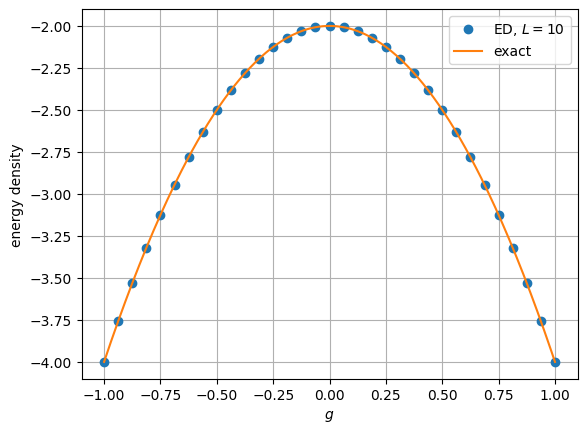

In [ ]:
def ene_exact(x):
  return -2*(x**2+1)
xx = np.linspace(-1,1,257)
yy = ene_exact(xx)

plt.grid()
plt.xlabel(r"$g$")
plt.ylabel(r"energy density")
plt.plot(dat[:,0],dat[:,1],"o",label=r"ED, $L=10$")
plt.plot(xx,yy,"-",label=r"exact")
plt.legend()
plt.show()
plt.close()